In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Import các thư viện cần thiết và cấu hình

In [ ]:
## Import cac thu vien can thiet
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from PIL import Image
import warnings
from tqdm import tqdm 
warnings.filterwarnings('ignore')
# TensorFlow va Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
# Sklearn cho danh gia
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
# Thiet lap style cho bieu do
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
# Kiem tra GPU
print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))
# Thiet lap seed de ket qua co the tai tao
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

2025-12-21 08:37:29.317666: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766306249.507141      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766306249.563553      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766306250.039436      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766306250.039480      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766306250.039483      24 computation_placer.cc:177] computation placer alr

TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# Cấu hình hệ thống và siêu tham số
CONFIG = {
    # KAGGLE PATHS
    'TRAIN_DIR': '/kaggle/input/chicken-disease-1/Train',
    'CSV_PATH': '/kaggle/input/chicken-disease-1/train_data.csv',
    # Model params
    'IMG_SIZE': 224,
    'BATCH_SIZE': 32,
    'EPOCHS': 100,
    'VALIDATION_SPLIT': 0.2,
    'SEED': 42,
    'NUM_CLASSES': 4,
    'LEARNING_RATE': 1e-4,
    'VALIDATION_SPLIT': 0.2
}
CLASS_NAMES = ['Coccidiosis', 'Healthy', 'New Castle Disease', 'Salmonella']
NUM_CLASSES = len(CLASS_NAMES)
SEED = CONFIG['SEED']
np.random.seed(SEED)
tf.random.set_seed(SEED)
print("Configuration loaded!")

Configuration loaded!


## Khám phá dữ liệu(EDA)

In [ ]:
# Doc file CSV
df = pd.read_csv(CONFIG['CSV_PATH'])
print("Thong tin co ban ve dataset:")
print(f"   Tong so mau: {len(df)}")
print(f"   So cot: {len(df.columns)}")
print("\n5 dong dau tien:")
df.head()

Thong tin co ban ve dataset:
   Tong so mau: 8067
   So cot: 2

5 dong dau tien:


images               label
0  salmo.1558.jpg          Salmonella
1  cocci.1866.jpg         Coccidiosis
2   cocci.171.jpg         Coccidiosis
3  salmo.1484.jpg          Salmonella
4     ncd.100.jpg  New Castle Disease

Phan bo cac lop:
label
Salmonella            2625
Coccidiosis           2476
Healthy               2404
New Castle Disease     562
Name: count, dtype: int64


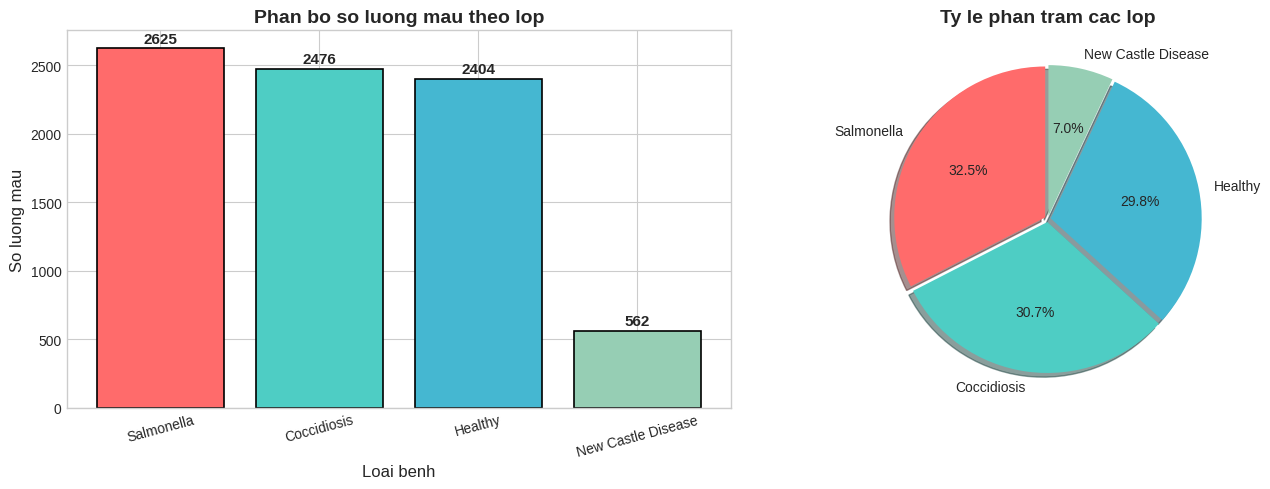


Da luu bieu do: class_distribution.png


In [ ]:
# Thong ke ve cac lop
print("Phan bo cac lop:")
class_distribution = df['label'].value_counts()
print(class_distribution)
# Visualize phan bo
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
# Bar chart
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
bars = axes[0].bar(class_distribution.index, class_distribution.values, color=colors, edgecolor='black', linewidth=1.2)
axes[0].set_xlabel('Loai benh', fontsize=12)
axes[0].set_ylabel('So luong mau', fontsize=12)
axes[0].set_title('Phan bo so luong mau theo lop', fontsize=14, fontweight='bold')
axes[0].tick_params(axis='x', rotation=15)
# Them so lieu tren bar
for bar, value in zip(bars, class_distribution.values):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20, 
                 str(value), ha='center', va='bottom', fontweight='bold', fontsize=11)

# Pie chart
axes[1].pie(class_distribution.values, labels=class_distribution.index, autopct='%1.1f%%',
            colors=colors, explode=[0.02]*4, shadow=True, startangle=90)
axes[1].set_title('Ty le phan tram cac lop', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('class_distribution.png', dpi=150, bbox_inches='tight')
plt.show()
print("\nDa luu bieu do: class_distribution.png")

Mất cân bằng dữ liệu (Imbalanced Data):
- Ba lớp Salmonella, Coccidiosis, và Healthy có số lượng khá cân bằng (tầm 2400-2600 ảnh).
- Lớp New Castle Disease (NCD) có số lượng rất ít (chỉ 562 ảnh), thấp hơn nhiều so với các lớp còn lại. Điều này có thể khiến mô hình dự đoán kém trên lớp này nếu không có biện pháp xử lý.

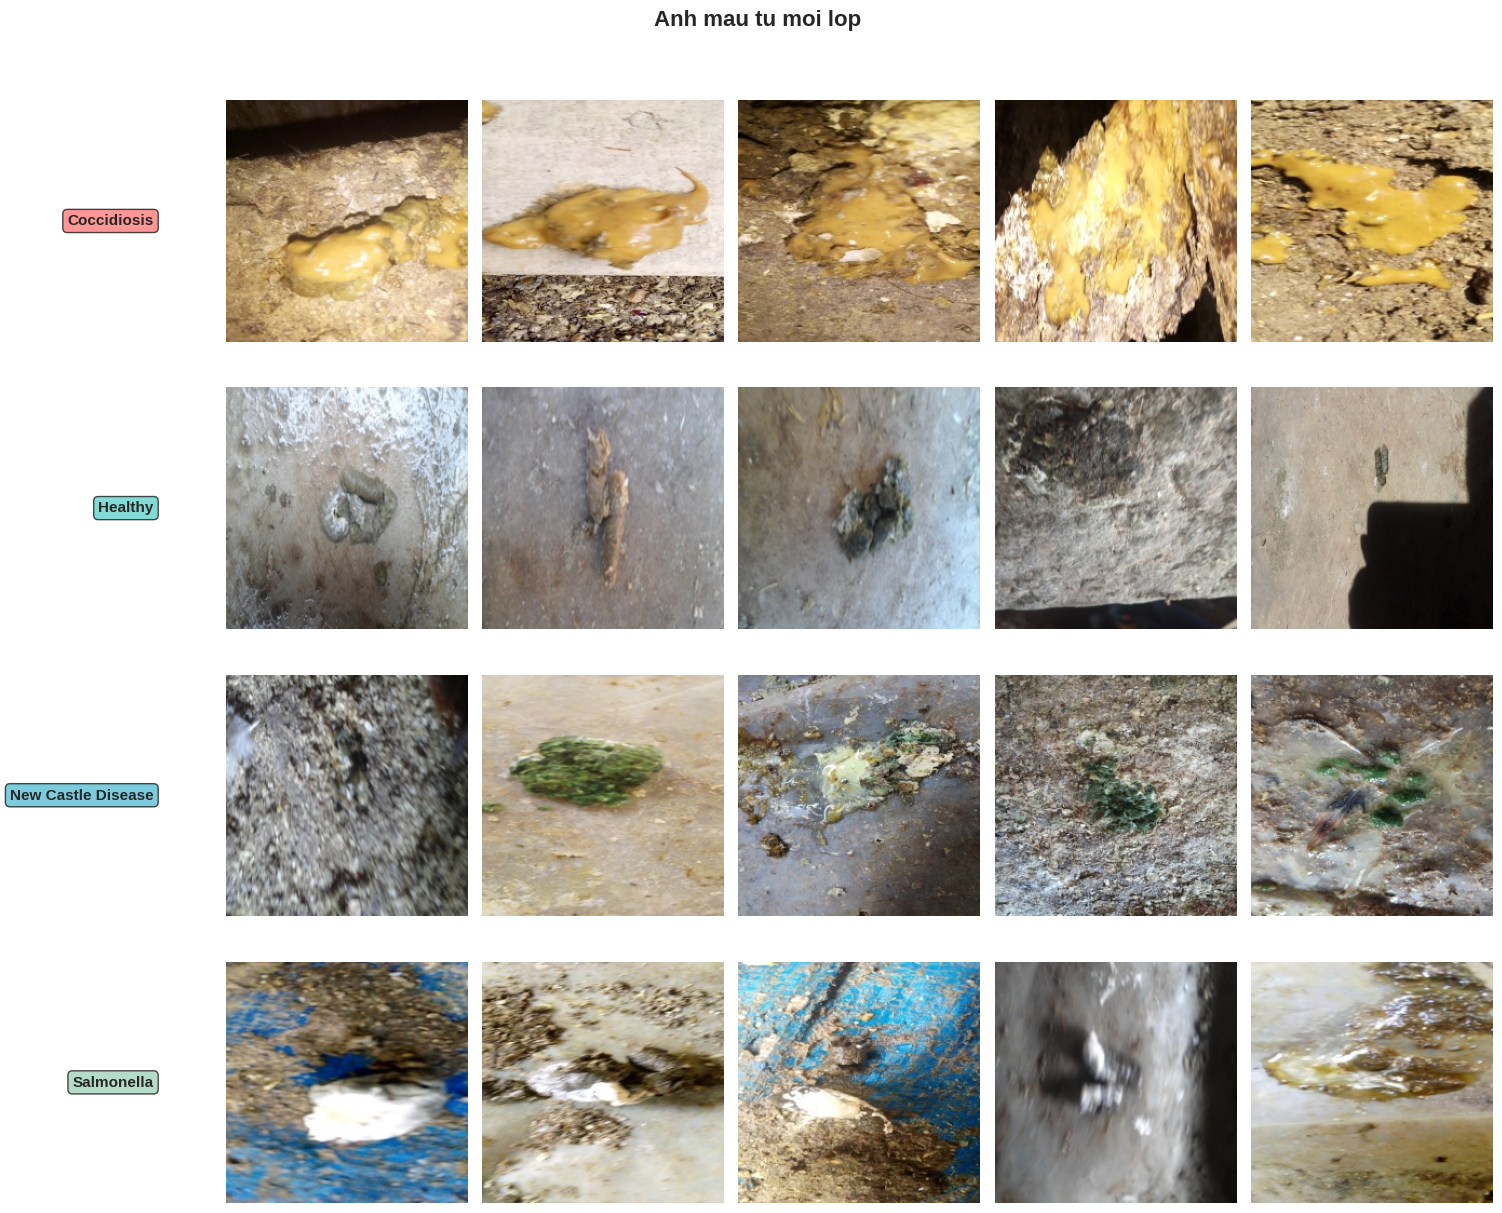

Da luu bieu do: sample_images.png


In [6]:
# Hien thi anh mau tu moi lop
fig, axes = plt.subplots(4, 5, figsize=(15, 12))

for i, class_name in enumerate(CLASS_NAMES):
    # Lay 5 anh mau tu moi lop
    class_samples = df[df['label'] == class_name]['images'].values[:5]
    
    for j, img_name in enumerate(class_samples):
        img_path = os.path.join(CONFIG['TRAIN_DIR'], img_name)
        if os.path.exists(img_path):
            img = Image.open(img_path)
            axes[i, j].imshow(img)
            axes[i, j].axis('off')
            if j == 0:
                axes[i, j].set_ylabel(class_name, fontsize=12, fontweight='bold', rotation=0, 
                                       labelpad=60, va='center')
        else:
            axes[i, j].text(0.5, 0.5, 'Not Found', ha='center', va='center')
            axes[i, j].axis('off')

# Them tieu de cho moi hang
for i, class_name in enumerate(CLASS_NAMES):
    axes[i, 0].annotate(class_name, xy=(-0.3, 0.5), xycoords='axes fraction',
                        fontsize=11, fontweight='bold', ha='right', va='center',
                        bbox=dict(boxstyle='round,pad=0.3', facecolor=colors[i], alpha=0.7))

plt.suptitle('Anh mau tu moi lop', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('sample_images.png', dpi=150, bbox_inches='tight')
plt.show()

print("Da luu bieu do: sample_images.png")

Bệnh Cầu trùng (Coccidiosis): Đặc trưng bởi hiện tượng "phân sáp" với màu nâu sẫm, vàng cam hoặc đỏ tươi do lẫn máu. Phân thường ướt, nhầy nhụa, có chứa dịch nhầy hoặc niêm mạc ruột bị bong tróc, không thành khuôn rõ ràng.

Bệnh Thương hàn (Salmonella): Điển hình là phân màu trắng đục như vôi hoặc trắng vàng (bệnh phân trắng). Phân có kết cấu dạng lỏng hoặc bệt dính, thường gây hiện tượng bết dông quanh hậu môn ở gà con, kèm theo mùi hôi tanh đặc trưng.

Bệnh Newcastle (Gà rù): Biểu hiện bằng tình trạng tiêu chảy nặng, phân rất loãng và nhiều nước. Màu sắc đặc trưng là xanh lá cây (xanh nõn chuối) pha lẫn các vệt trắng của axit uric, do gà bỏ ăn và dịch mật làm thay đổi màu sắc chất thải.

Trạng thái Khỏe mạnh (Healthy): Phân khô ráo, có khuôn hình xoắn ốc hoặc trụ rõ ràng. Màu sắc thường là nâu xám hoặc xám đen, luôn có một chóp trắng (urat) ở phía trên đầu, cho thấy hệ tiêu hóa và bài tiết hoạt động bình thường.

Phan tich thuoc tinh anh...

Thong ke kich thuoc anh:
   Width  - Min: 224, Max: 224, Mean: 224.0
   Height - Min: 224, Max: 224, Mean: 224.0
   Channels: {3}


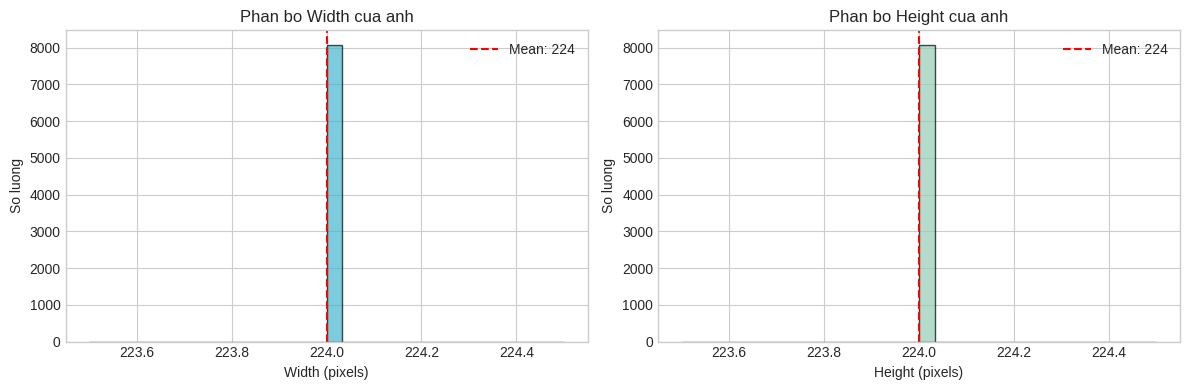

In [7]:
# Phan tich kich thuoc va thuoc tinh anh
print("Phan tich thuoc tinh anh...")

img_widths = []
img_heights = []
img_channels = []

for img_name in df['images'].values: 
    img_path = os.path.join(CONFIG['TRAIN_DIR'], img_name)
    if os.path.exists(img_path):
        img = Image.open(img_path)
        img_widths.append(img.size[0])
        img_heights.append(img.size[1])
        if img.mode == 'RGB':
            img_channels.append(3)
        elif img.mode == 'L':
            img_channels.append(1)
        else:
            img_channels.append(len(img.mode))

print(f"\nThong ke kich thuoc anh:")
print(f"   Width  - Min: {min(img_widths)}, Max: {max(img_widths)}, Mean: {np.mean(img_widths):.1f}")
print(f"   Height - Min: {min(img_heights)}, Max: {max(img_heights)}, Mean: {np.mean(img_heights):.1f}")
print(f"   Channels: {set(img_channels)}")

# Histogram kich thuoc anh
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(img_widths, bins=30, color='#45B7D1', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Width (pixels)')
axes[0].set_ylabel('So luong')
axes[0].set_title('Phan bo Width cua anh')
axes[0].axvline(np.mean(img_widths), color='red', linestyle='--', label=f'Mean: {np.mean(img_widths):.0f}')
axes[0].legend()

axes[1].hist(img_heights, bins=30, color='#96CEB4', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Height (pixels)')
axes[1].set_ylabel('So luong')
axes[1].set_title('Phan bo Height cua anh')
axes[1].axvline(np.mean(img_heights), color='red', linestyle='--', label=f'Mean: {np.mean(img_heights):.0f}')
axes[1].legend()

plt.tight_layout()
plt.show()

Toàn bộ 8,067 ảnh trong dataset đều có cùng một kích thước duy nhất là 224 x 224 pixels (Width = 224, Height = 224).



In [8]:
print("Phan tich Brightness va Contrast...")
img_brightness = []
img_contrast = []
for img_name in tqdm(df['images'].values, desc="Analyzing"):
    img_path = os.path.join(CONFIG['TRAIN_DIR'], img_name)
    if os.path.exists(img_path):
        img = cv2.imread(img_path)
        if img is not None:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img_brightness.append(np.mean(gray))
            img_contrast.append(np.std(gray))
print(f"\nTong so anh: {len(img_brightness)}")
print(f"Brightness - Min: {min(img_brightness):.1f}, Max: {max(img_brightness):.1f}, Mean: {np.mean(img_brightness):.1f}")
print(f"Contrast   - Min: {min(img_contrast):.1f}, Max: {max(img_contrast):.1f}, Mean: {np.mean(img_contrast):.1f}")
# Danh gia
dark_images = sum(1 for b in img_brightness if b < 80)
bright_images = sum(1 for b in img_brightness if b > 180)
low_contrast = sum(1 for c in img_contrast if c < 30)
print(f"\nAnh toi (brightness < 80): {dark_images} ({dark_images/len(img_brightness)*100:.1f}%)")
print(f"Anh sang qua (brightness > 180): {bright_images} ({bright_images/len(img_brightness)*100:.1f}%)")
print(f"Anh tuong phan thap (contrast < 30): {low_contrast} ({low_contrast/len(img_contrast)*100:.1f}%)")

Phan tich Brightness va Contrast...


Analyzing: 100%|██████████| 8067/8067 [00:19<00:00, 423.30it/s]


Tong so anh: 8067
Brightness - Min: 12.2, Max: 217.8, Mean: 140.1
Contrast   - Min: 4.5, Max: 100.6, Mean: 39.9

Anh toi (brightness < 80): 120 (1.5%)
Anh sang qua (brightness > 180): 484 (6.0%)
Anh tuong phan thap (contrast < 30): 2023 (25.1%)


Brightness (Độ sáng)
 - Mean = 140.1 (thang 0-255): Ảnh trung bình hơi sáng một chút so với mức giữa (127.5)
 - 1.5% ảnh tối (<80): Rất ít ảnh bị thiếu sáng
 - 6.0% ảnh sáng quá (>180): Ít ảnh bị quá sáng

   -> Dataset có độ sáng khá đồng đều

Contrast (Độ tương phản)
 - Mean = 39.9: Mức trung bình
 - 25.1% ảnh có contrast thấp (<30): 1/4 dataset có ảnh với độ tương phản thấp
 - Ảnh contrast thấp nghĩa là:

Chi tiết mờ, không rõ ràng, màu sắc ít biến đổi, khó phân biệt đặc điểm giữa các vùng trong ảnh


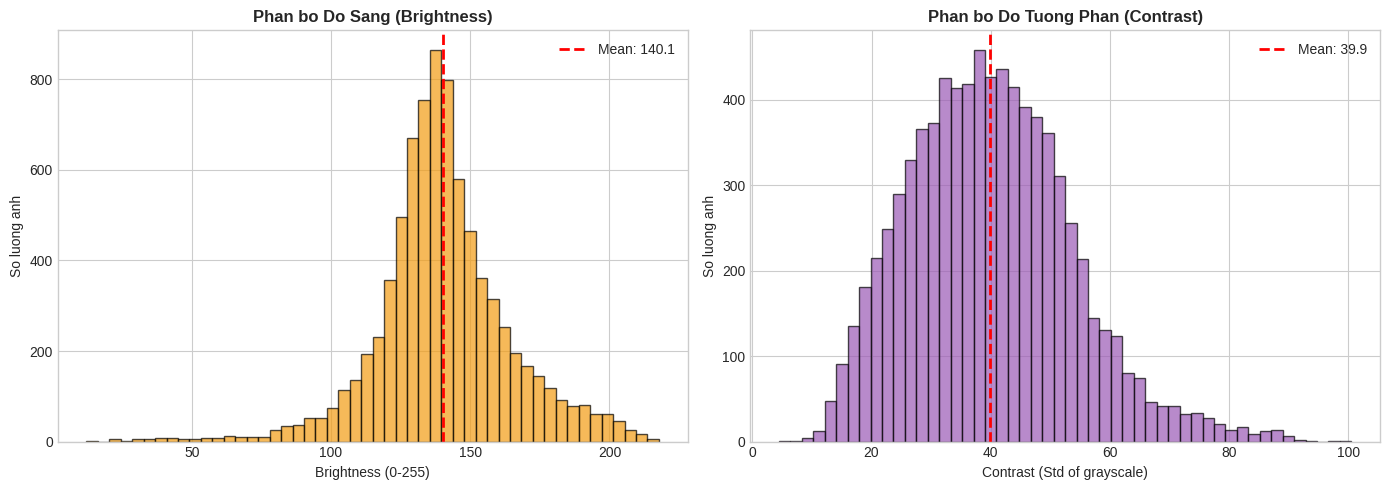

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].hist(img_brightness, bins=50, color='#f39c12', edgecolor='black', alpha=0.7)
axes[0].axvline(np.mean(img_brightness), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(img_brightness):.1f}')
axes[0].set_xlabel('Brightness (0-255)')
axes[0].set_ylabel('So luong anh')
axes[0].set_title('Phan bo Do Sang (Brightness)', fontweight='bold')
axes[0].legend()
axes[1].hist(img_contrast, bins=50, color='#9b59b6', edgecolor='black', alpha=0.7)
axes[1].axvline(np.mean(img_contrast), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(img_contrast):.1f}')
axes[1].set_xlabel('Contrast (Std of grayscale)')
axes[1].set_ylabel('So luong anh')
axes[1].set_title('Phan bo Do Tuong Phan (Contrast)', fontweight='bold')
axes[1].legend()

plt.tight_layout()
plt.show()

Biểu đồ Brightness (Độ sáng) - Bên trái
Nhận xét:
- Phân bố theo hình chuông (Normal distribution) → Dataset có chất lượng tốt về độ sáng
- Đỉnh tập trung quanh 120-150 (gần giữa thang đo 0-255)
- Rất ít ảnh ở hai cực (quá tối <50 hoặc quá sáng >200)
- Mean = 140.1 → Hơi lệch về phía sáng nhưng không đáng kể
- Kết luận: Độ sáng dataset tốt, không cần xử lý đặc biệt.

Biểu đồ Contrast (Độ tương phản) - Bên phải
Nhận xét:
- Phân bố lệch phải (right-skewed) → Có nhiều ảnh tập trung ở vùng contrast thấp
- Vùng 10-30: Chiếm tỷ lệ đáng kể (~25% dataset)
- Mean = 39.9 → Mức trung bình-thấp
- Ít ảnh có contrast cao (>70)
- Kết luận: Có vấn đề với độ tương phản
- 1/4 ảnh có contrast thấp = ảnh mờ, chi tiết không rõ
- Đây có thể do điều kiện chụp (ánh sáng chuồng trại, camera kém...)

Ý nghĩa thực tế:
- Dataset phản ánh điều kiện thực tế của chuồng trại (ánh sáng không đồng đều, một số ảnh chất lượng kém)
- Model cần được huấn luyện để chịu được cả ảnh tốt lẫn ảnh kém chất lượng
- Phần ảnh contrast thấp là thách thức nhưng cũng là cơ hội để model học tổng quát hơn

Không cần điều chỉnh brightness mạnh. Chỉ cần thay đổi nhẹ trong khoảng 80%-120% độ sáng gốc là đủ để tạo đa dạng.
Ảnh contrast thấp = ảnh mờ, chi tiết không rõ ràng → Model sẽ khó học từ những ảnh này.Quyết định: Cần thêm Contrast Augmentation 




Phan tich phan bo mau sac RGB...


Analyzing RGB: 100%|██████████| 100/100 [00:01<00:00, 88.51it/s]


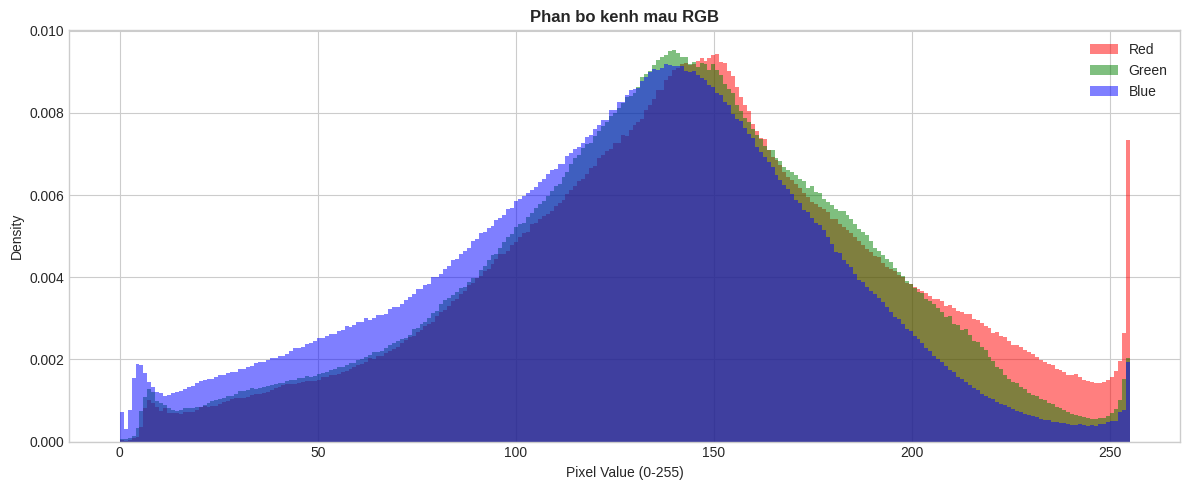

In [ ]:
print("Phan tich phan bo mau sac RGB...")
sample_size = min(100, len(df))
sample_imgs = df['images'].sample(sample_size, random_state=SEED).values
all_r, all_g, all_b = [], [], []
for img_name in tqdm(sample_imgs, desc="Analyzing RGB"):
    img_path = os.path.join(CONFIG['TRAIN_DIR'], img_name)
    if os.path.exists(img_path):
        img = cv2.imread(img_path)
        if img is not None:
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            all_r.extend(img_rgb[:, :, 0].flatten())
            all_g.extend(img_rgb[:, :, 1].flatten())
            all_b.extend(img_rgb[:, :, 2].flatten())
fig, ax = plt.subplots(figsize=(12, 5))
ax.hist(all_r, bins=256, color='red', alpha=0.5, label='Red', density=True)
ax.hist(all_g, bins=256, color='green', alpha=0.5, label='Green', density=True)
ax.hist(all_b, bins=256, color='blue', alpha=0.5, label='Blue', density=True)
ax.set_xlabel('Pixel Value (0-255)')
ax.set_ylabel('Density')
ax.set_title('Phan bo kenh mau RGB', fontweight='bold')
ax.legend()
plt.tight_layout()
plt.show()

Ba kênh chồng lấp mạnh ở vùng 100-170 -> Ảnh có nhiều tông màu nâu/be (đặc trưng của nền trấu, phân gà)

Red > Green > Blue ở vùng cao (150-250) -> Ảnh nghiêng về tông ấm (warm tone). Phù hợp với màu phân gà (nâu, cam, đỏ nâu)
Spike của Red tại 255 -> Một số ảnh có vùng bão hòa màu đỏ (có thể là máu trong phân bệnh hoặc ánh sáng đèn)

Blue có đỉnh nhỏ tại 0 -> Có vùng tối thiếu ánh sáng xanh

Ý nghĩa thực tế:
- Màu sắc phản ánh đúng đặc trưng của phân gà trên nền trấu
- Model có thể học được sự khác biệt màu sắc giữa các loại bệnh (phân có máu vs phân bình thường)
- Không cần color augmentation mạnh vì màu sắc là thông tin quan trọng để phân loại

Màu sắc trong dataset này có ý nghĩa y học (phân có máu vs phân bình thường). Vì vậy, không nên thay đổi màu sắc quá nhiều trong data augmentation để model vẫn học được sự khác biệt màu giữa các loại bệnh

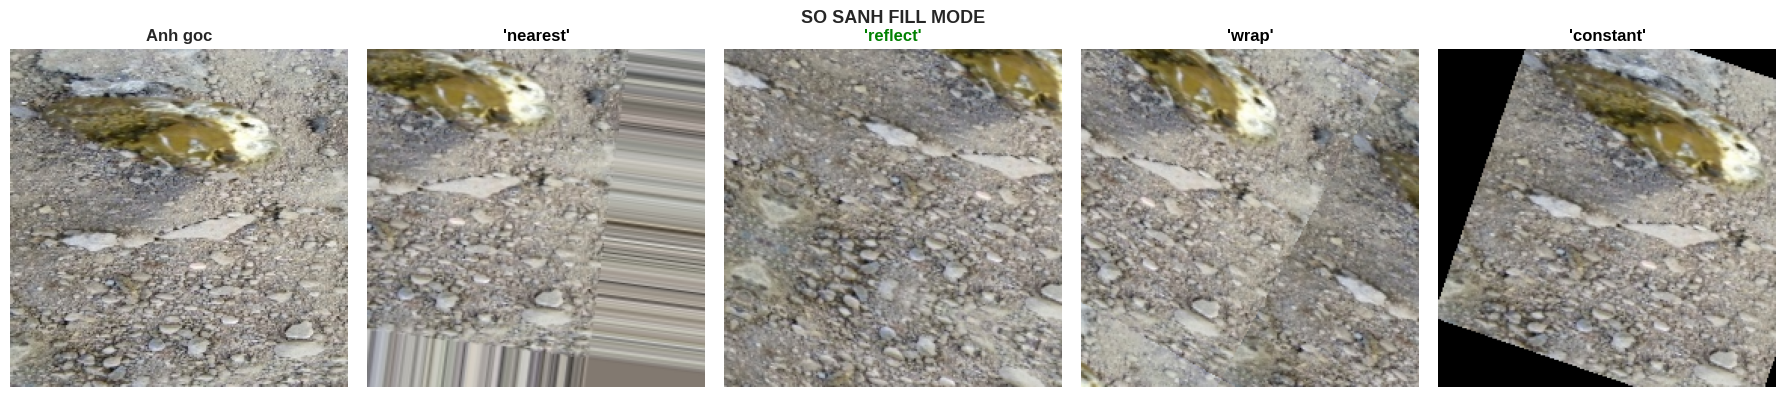

In [ ]:
# So sanh Fill Mode
from tensorflow.keras.preprocessing.image import load_img, img_to_array

sample_path = os.path.join(CONFIG['TRAIN_DIR'], df['images'].sample(1, random_state=SEED).values[0])
sample_arr = img_to_array(load_img(sample_path, target_size=(224, 224))).reshape(1, 224, 224, 3)
fig, axes = plt.subplots(1, 5, figsize=(18, 4))
axes[0].imshow(sample_arr[0].astype('uint8'))
axes[0].set_title('Anh goc', fontweight='bold')
axes[0].axis('off')
for i, mode in enumerate(['nearest', 'reflect', 'wrap', 'constant']):
    datagen = ImageDataGenerator(rotation_range=30, width_shift_range=0.3, 
                                  height_shift_range=0.3, fill_mode=mode, cval=0)
    aug_img = next(datagen.flow(sample_arr, batch_size=1))[0].astype('uint8')
    axes[i+1].imshow(aug_img)
    axes[i+1].set_title(f"'{mode}'" + ('' if mode == 'reflect' else ''), 
                        fontweight='bold', color='green' if mode == 'reflect' else 'black')
    axes[i+1].axis('off')
plt.suptitle("SO SANH FILL MODE",fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

Với ảnh phân trên nền trấu (texture đồng nhất), fill_mode='reflect' tạo ra viền mềm mại, tự nhiên nhất khi xoay/dịch ảnh.